# Tarea 3: Diseño Avanzado de Algoritmos

## Spark: k-means

### Daniel San Martín

### Spark

Apache Spark es un framework open-source de computación en clúster de propósito general y orientado a la velocidad. Proporciona APIs en Java, Scala, Python y R.

In [1]:
# Python version 3.7.3
import os 
import numpy as np # Version 1.16.4
import pandas as pd # Version 0.24.2
import matplotlib.pyplot as plt # Version 3.1.0
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.decomposition import PCA # Version 0.21.2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances 
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_DIR = 'data/dataset.csv'

### Funciones auxiliares

Implementación de funciones para la representacion de datos, graficar y obtener resultados.

In [3]:
# Get data as numpy array or dictionary
def dataRepresentation(data, matrix=True): 
    M, N = np.max(data['source']), np.max(data['target'])  
    m = np.zeros((M, N))
    d = dict()
    
    # Read data and create the representation
    for index, row in data.iterrows():
        s, t, r = row['source'], row['target'], row['rating']
        m[s-1, t-1] = r
        if s not in d:
            d[s] = np.zeros(N)
        d[s][t-1] = r
    
    if matrix: # Return as numpy array
        # Remove rows/cols with only zeros
        m = m[~np.all(m == 0, axis=1)]
        m = m[:,~np.all(m == 0, axis=0)]
        return m
    else: # Return as dictionary
        return d

In [4]:
# Results boxplots
def boxplot(data, times=True):
    N = len(data)
    fig, axes = plt.subplots(1, N, figsize=(15, 5), sharey=True)
    for k in range(N):
        axes[k].boxplot(data[k])
        axes[k].set_title("K = " + str((k+1)*10))
        axes[k].grid(True)
    plt.tight_layout()
    plt.show()        

In [83]:
# Scatter for 2D projection of data using PCA (only exploratory)
def scatter(data, means=None, lims=[[-10, 20], [-10, 80]]):
    fig = plt.figure(figsize=(14, 4))
    
    # All data
    plt.subplot(1, 2, 1)
    plt.scatter(data[:,0], data[:,1])
    if means is not None:
        plt.scatter(means[:,0], means[:,1], marker="*")
    plt.grid(True)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
        
    # "Zoom"
    plt.subplot(1, 2, 2)
    plt.scatter(data[:,0], data[:,1])
    if means is not None:
        plt.scatter(means[:,0], means[:,1], marker="*")
    plt.xlim(lims[0])
    plt.ylim(lims[1])
    
    plt.grid(True)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.show()

In [6]:
def histograms(sim, dis):
    # Remove duplicated data for symmetry of similarity/distance matrix
    data_sim, data_dis = [], []
    M, N = sim.shape
    for i in range(M):
        for j in range(i+1, N):
            data_sim.append(sim[i, j])
            data_dis.append(dis[i, j])
    data_sim = np.array(data_sim)
    data_dis = np.array(data_dis)
    
    # Plots
    fig = plt.figure(figsize=(14, 4))
    
    # Similarity
    plt.subplot(1, 2, 1)
    plt.hist(data_sim, bins=20)
    plt.grid(True)
    plt.title("Cosine Similarity")
    
    # Distance
    plt.subplot(1, 2, 2)
    plt.hist(data_dis, bins=20)
    plt.grid(True)
    plt.title("Cosine Distance")
    plt.show()

In [7]:
# Get results filenames
def getFiles(path, K):
    names = list()
    for k in K:
        path_k = path + str(k) + "/"
        for _, _, files in os.walk(path_k):
            for file in files:
                if '.txt' in file:
                    names.append(path_k + file)
    return names

In [8]:
# Get data from results files
def getResults(path, K):
    file_names = getFiles(path, K)
    k_10, k_20, k_30, k_40, k_50 = [], [], [], [], []
    for name in file_names:
        if '/10/' in name: result = np.genfromtxt(name, delimiter=','); k_10.append(result)
        elif '/20/' in name: result = np.genfromtxt(name, delimiter=','); k_20.append(result)
        elif '/30/' in name: result = np.genfromtxt(name, delimiter=','); k_30.append(result)
        elif '/40/' in name: result = np.genfromtxt(name, delimiter=','); k_40.append(result)
        elif '/50/' in name: result = np.genfromtxt(name, delimiter=','); k_50.append(result)
    return k_10, k_20, k_30, k_40, k_50  

### Formato de entrada

Se entrega un dataset en csv, donde cada fila contiene la siguiente información: ID_SOURCE, ID_TARGET, RATING
donde:
* ID_SOURCE: ID de usuario origen
* ID_TARGET: ID del usuario destino
* RATING: calificación del trust de ID_SOURCE sobre ID_TARGET, en $\{-10,10\}$

#### Descripción básica

Estadísticas generales de los datos.

In [9]:
data = pd.read_csv(DATA_DIR, header=None, names=['source', 'target', 'rating'])

In [10]:
data.describe()

,source,target,rating
count,24186.000000,24186.000000,24186.000000
mean,864.029314,1051.093815,1.463946
std,1592.085638,1871.765504,2.903656
min,1.000000,1.000000,-10.000000
25%,58.000000,66.000000,1.000000
50%,238.000000,279.000000,1.000000
75%,898.000000,1068.000000,2.000000
max,7604.000000,7604.000000,10.000000


### Algoritmo k–means

- Defina la función parse_vector para que lea el dataset y cree una RDD o DataFrame en Spark de vectores de usuarios. La representación vectorial de los usuarios corresponde a vectores donde cada componente es el rating. Por ejemplo, para el vector $u$ del usuario $i$, la componente $j$ corresponde a $RATING(i,j)$. Su RDD de vectores debe tener $n-1$ slices, donde $n$ es el número de cores de su máquina. 

En el pre-procesamiento de datos se utilizó `dataRepresentation(data)` para forma convertir los datos según lo solicitado.

In [11]:
#dr = dataRepresentation(data)
#np.savetxt('data/pro.csv', dr, fmt='%d', delimiter=',')
dr = np.genfromtxt('./data/pro.csv', delimiter=',')
pd.DataFrame(dr).describe()

,0,1,2,3,4,5,6,7,8,9,...,3744,3745,3746,3747,3748,3749,3750,3751,3752,3753
count,3286.000000,3286.000000,3286.000000,3286.000000,3286.000000,3286.000000,3286.000000,3286.000000,3286.000000,3286.000000,...,3286.000000,3286.000000,3286.000000,3286.000000,3286.000000,3286.000000,3286.000000,3286.000000,3286.00000,3286.000000
mean,0.230676,0.223676,0.185636,0.178941,0.118685,0.118077,0.112599,0.104991,0.097687,0.087645,...,-0.019477,-0.020998,-0.027389,-0.033475,-0.033475,-0.036214,-0.036519,-0.045648,-0.06482,-0.191114
std,0.858505,1.169709,0.819615,0.903702,0.787597,0.739449,0.886279,0.652539,0.743852,0.523063,...,0.599531,0.462786,0.522707,0.759780,0.759780,0.811014,0.696942,0.717927,1.01813,1.446770
min,0.000000,0.000000,-2.000000,0.000000,-10.000000,0.000000,-10.000000,0.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.00000,-10.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,8.000000,...,7.000000,2.000000,0.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000


### Para tener alguna idea...

In [12]:
ds = StandardScaler().fit_transform(dr)
X = np.copy(ds)
pca = PCA(n_components=2)
fit = pca.fit(X) 

In [13]:
dpca = pca.transform(X)

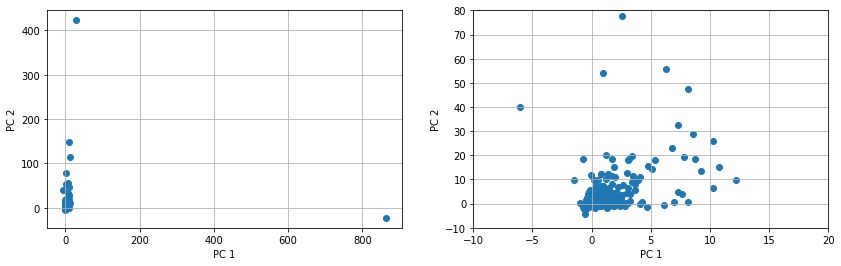

In [14]:
scatter(dpca)

La función `parse_vector(filename, n)` recibe el nombre del archivo y la cantidad de cores de la máquina. Toma cada línea del archivo y aplica un *split* retornando un vector con $N_{c}$ `Doubles`, donde $N_{c}$ es el número de componentes del vector. Luego retorna el `RDD` de vectores con $n-1$ slices.
```scala
def parse_vector(filename: String, n: Int) = {
    val lines = sc.textFile(filename, n - 1)
    val data = lines.map(l => 
        Vector(l.split(',').map(_.toDouble))
    ).cache()
    data
}
```

In [15]:
!sysctl hw.physicalcpu hw.logicalcpu

hw.physicalcpu: 2
hw.logicalcpu: 4


El valor escogido como número de cores fue $4$.

- Defina la función similitud de coseno en los primeros dos cuadrantes del plano cartesiano para que pueda medir la similitud entre dos vectores cuyas componentes tienen valores en el intervalo discreto $\{-10, 10\}$.

### Similitud del Coseno <small>[1]</small>

La similitud del Coseno calcula la similaridad como el producto punto normalizado de dos vectores $\mathbf{x}_i$ y $\mathbf{x}_j$:

\begin{equation}
    Sim(\mathbf{x}_i,\mathbf{x}_j) = \frac{\mathbf{x}_i\cdot\mathbf{x}_j}{||\mathbf{x}_i||\,||\mathbf{x}_j||}
\end{equation}

La función en `Scala` recibe dos vectores $\mathbf{x}$, $\mathbf{y}$ y retorna $Sim(\mathbf{x},\mathbf{y})$
```scala
def cosineSimilarity(x: Vector[Double], y: Vector[Double]): Double = {
    val denom = norm(x) * norm(y)
    val dotProduct = x dot y
    if (denom == 0.0) {
      0.0
    } else {
      dotProduct / denom
    }
}
```

Para el análisis previo se implementaría en `Python`de la siguiente forma, recibiendo como parámetro la matriz de datos.
```Python
def cos_sim(X):
    M, N = X.shape
    sim = np.zeros((M, M))
    for i in range(M):
        for j in range(M):
            sim[i, j] = np.dot(X[i], X[j]) / (np.linalg.norm(X[i]) * np.linalg.norm(X[j]))
    return sim
```
Ahora, dado que computacionalmente es muy costoso, se utiliza la función ```cosine_similarity(X)``` que proporciona la biblioteca ```sklearn.metrics.pairwise``` y que se encuentra optimizada. 

### Distancia del Coseno

Dado que queremos analizar la "cercanía" de los vectores de usuarios, utilizaremos la distancia del coseno definida como

\begin{equation}
    Dist(\mathbf{x}_i,\mathbf{x}_j) = 1 - Sim(\mathbf{x}_i,\mathbf{x}_j)
\end{equation}

Dado que el cómputo es igual de costoso que la similitud del coseno, se utilizará la función `cosine_distances(X)` de `sklearn.metrics.pairwise`. Para el caso de `Scala` esta función se encuentra implementada como `cosineDistance(x,y)` dentro de la biblioteca `breeze.linalg.functions`.

- Implemente el algoritmo k-means en Spark para que corra sobre el dataset entregado. Puede reusar el código comentado en clases. Extiéndalo para que pueda trabajar sobre los datos de esta tarea.

Primero, una breve descripción del algoritmo.

## k-means clustering <small>[2]</small>

Dado un conjunto de datos $(x_1, x_2, ..., x_n)$, $x_i\in\mathbb{R}^d, \, i=1, ..., n$, $k$-means busca particionar los $n$ datos en $k$ ($\leq n$) conjuntos $S = {S_1, S_2, ..., S_k}$ minimizando el la varianza entre *clusters*. Formalmente, el objetivo es encontrar
\begin{equation}
{\underset {\mathbf {S} }{\operatorname {arg\,min} }}\sum _{i=1}^{k}\sum _{\mathbf {x} \in S_{i}}\left\|\mathbf {x} -{\boldsymbol {\mu }}_{i}\right\|^{2}={\underset {\mathbf {S} }{\operatorname {arg\,min} }}\sum _{i=1}^{k}|S_{i}|\operatorname {Var} S_{i}
\end{equation}

donde $\mu_i$ es la media de los puntos en $S_i$. Esto es equivalente a minimizar la desviación al cuadrado entre pares de puntos del mismo *cluster*:

\begin{equation}
{\underset {\mathbf {S} }{\operatorname {arg\,min} }}\sum _{i=1}^{k}\,{\frac {1}{2|S_{i}|}}\,\sum _{\mathbf {x} ,\mathbf {y} \in S_{i}}\left\|\mathbf {x} -\mathbf {y} \right\|^{2}
\end{equation}

Notar que para este trabajo se utiliza la *Distancia del Coseno* en vez de la desviación al cuadrado.

### Algoritmo


Dado un conjunto inicial de $k$ medias $m_1^{(1)}, ..., m_k^{(1)}$, el algoritmo funciona alternando los siguientes dos pasos:

1. **Asignación**: Asignar cada dato al *cluster* cuya media tenga la menor distancia, esto es intuitivamente la media "más cercana".

\begin{equation}
S_{i}^{(t)}={\big \{}x_{p}:Dist(x_{p},m_{i}^{(t)})\leq Dist(x_{p},m_{j}^{(t)})\ \forall j,1\leq j\leq k{\big \}}
\end{equation}

donde cada $x_{p}$ es asignado exactamente a un $S^{(t)}$, aun si este pudiera ser asignado a dos o más conjuntos.

2. **Actualización**: Calcular la nueva media (centroide) de los datos en los nuevos *clusters*.

\begin{equation}
    m_{i}^{(t+1)}={\frac {1}{\left|S_{i}^{(t)}\right|}}\sum _{x_{j}\in S_{i}^{(t)}}x_{j}
\end{equation}

### Implementación en Scala

```scala
// Conjunto inicial de k medias
val kPoints = data.takeSample(withReplacement=false, k, System.currentTimeMillis).toArray
var tempDist = 1.0	
var iter = 0
while (tempDist > convergeDist) {
    // Asignacion de cada dato a un respectivo cluster
    val closest = data.map(p => (closestPoint(p, kPoints), (p, 1)))
    val pointStats = closest.reduceByKey{ case ((p1, c1), (p2, c2)) => (p1 + p2, c1 + c2) }
    
    // Actualizacion de los centroides
    val newPoints = pointStats.map{ pair =>
		(pair._1, pair._2._1 * (1.0 / pair._2._2))
	}.collectAsMap()
    
    // Revisar si hay 'convergencia' comparando los centroides de iter-1 con iter
    tempDist = 0.0
    for (i <- 0 until k) {
        tempDist += cosineDistance(kPoints(i), newPoints(i))
    }
    for (newP <- newPoints) kPoints(newP._1) = newP._2
    iter += 1
}
```

## Experimentación.

1.- Compute el histograma de similitudes entre los vectores ```Sim(ui,uj)```. Considere 20 bins para su histograma. Usando el histograma, defina un valor adecuado para convDist. Justifique su decisión.

In [16]:
sim = cosine_similarity(dr)
dis = cosine_distances(dr)

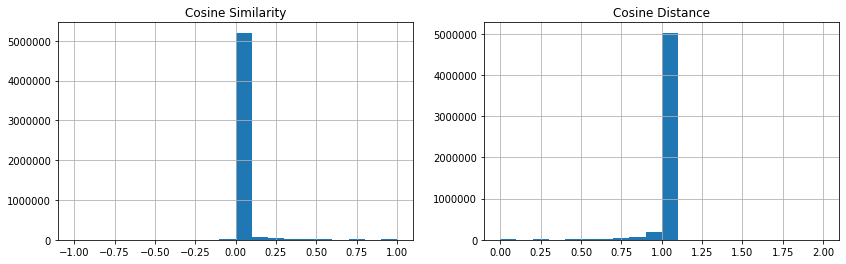

In [17]:
histograms(sim, dis)

Dado que la mayoría de puntos analizados se encuentran cercanos al valor $0$ (o $1$ si vemos el gráfico de la derecha), podemos suponer que los *rankings* de cada usuario no se parecen por lo tanto se escoge un valor de $convDist=0.001$. Dicho de otra forma, el algoritmo debería converger más o menos lento ya que los vectores tienden a ser ortogonales. Por esta razón se utiliza un valor relativamente pequeño para $convDist$ para obtener resultados en un tiempo prudente.

2.- Corra su algoritmo con los siguientes valores de $k = \{10, 20, 30, 40, 50\}$. Corra cada configuración 5 veces, registrando el número de iteraciones y el tiempo. Para cada valor de $k$, haga un box plot del tiempo de ejecución y otro del número de iteraciones. Comente sus resultados.

In [18]:
def experiment(k, convDist=0.001):
    start = time.time()
    !bash run.sh "./data/pro.csv" $k $convDist 2>/dev/null
    end = time.time()
    e_t = end - start
    print("Elapsed time: ", e_t)
    return e_t

### "Live Demo"

In [105]:
ld = experiment(10, 0.1)

Iterations: 5
Elapsed time:  55.13049912452698


In [20]:
K = list(range(10, 51, 10))
times = np.zeros((len(K), 5))

### $k=10$

In [21]:
times[0, 0] = experiment(10)

Iterations: 16
Elapsed time:  96.68977403640747


In [22]:
times[0, 1] = experiment(10)

Iterations: 17
Elapsed time:  132.7415590286255


In [23]:
times[0, 2] = experiment(10)

Iterations: 10
Elapsed time:  81.51960802078247


In [24]:
times[0, 3] = experiment(10)

Iterations: 31
Elapsed time:  168.8739368915558


In [25]:
times[0, 4] = experiment(10)

Iterations: 24
Elapsed time:  185.396479845047


### $k=20$

In [26]:
times[1, 0] = experiment(20)

Iterations: 15
Elapsed time:  111.96453619003296


In [27]:
times[1, 1] = experiment(20)

Iterations: 15
Elapsed time:  160.4166340827942


In [28]:
times[1, 2] = experiment(20)

Iterations: 15
Elapsed time:  221.09233283996582


In [29]:
times[1, 3] = experiment(20)

Iterations: 18
Elapsed time:  203.48249697685242


In [30]:
times[1, 4] = experiment(20)

Iterations: 11
Elapsed time:  164.61798572540283


### $k=30$

In [31]:
times[2, 0] = experiment(30)

Iterations: 18
Elapsed time:  274.56231904029846


In [32]:
times[2, 1] = experiment(30)

Iterations: 12
Elapsed time:  187.47768115997314


In [33]:
times[2, 2] = experiment(30)

Iterations: 11
Elapsed time:  204.5162308216095


In [35]:
times[2, 3] = experiment(30)

Iterations: 9
Elapsed time:  201.44304585456848


In [36]:
times[2, 4] = experiment(30)

Iterations: 11
Elapsed time:  189.88382387161255


### $k=40$

In [38]:
times[3, 0] = experiment(40)

Iterations: 10
Elapsed time:  231.36989784240723


In [39]:
times[3, 1] = experiment(40)

Iterations: 16
Elapsed time:  354.4967269897461


In [42]:
times[3, 2] = experiment(40)

Iterations: 15
Elapsed time:  330.2719519138336


In [44]:
times[3, 3] = experiment(40)

Iterations: 12
Elapsed time:  267.59576201438904


In [45]:
times[3, 4] = experiment(40)

Iterations: 8
Elapsed time:  178.10608291625977


### $k=50$

In [50]:
times[4, 0] = experiment(50)

Iterations: 9
Elapsed time:  240.53037309646606


In [56]:
times[4, 1] = experiment(50)

Iterations: 11
Elapsed time:  301.00403881073


In [57]:
times[4, 2] = experiment(50)

Iterations: 13
Elapsed time:  353.3671660423279


In [58]:
times[4, 3] = experiment(50)

Iterations: 12
Elapsed time:  444.3880958557129


In [59]:
times[4, 4] = experiment(50)

Iterations: 11
Elapsed time:  403.9678330421448


In [60]:
#np.savetxt('./data/output/times.csv', times, fmt='%f', delimiter=',')

In [61]:
res = getResults('./data/output/', K)

In [62]:
iterations = np.array([
    [int(r[0,0]) for r in res[0]],
    [int(r[0,0]) for r in res[1]],
    [int(r[0,0]) for r in res[2]],
    [int(r[0,0]) for r in res[3]],
    [int(r[0,0]) for r in res[4]]
])

## Boxplots

### Tiempos de ejecución

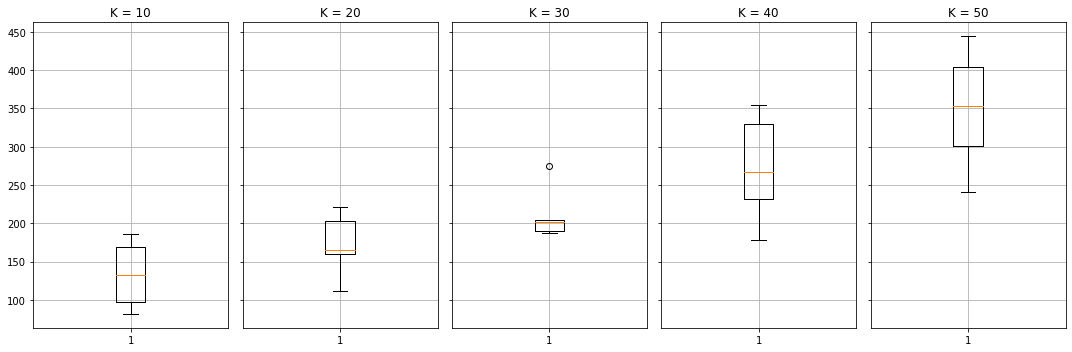

In [63]:
boxplot(times)

Es clara la necesidad de más tiempo de cómputo a medida que se incrementa el valor $k$. En la etapa de asignación es necesario que se recorran más conjuntos a medida que $k$ crece.

### Número de iteraciones

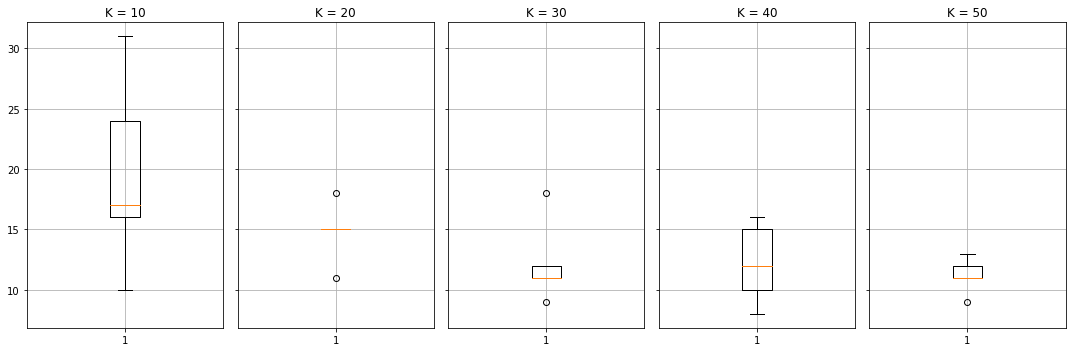

In [64]:
boxplot(iterations, False)

En este caso notamos que el número de iteraciones no cambia mucho al variar el valor de $k$. Puede tener relación al valor $convDist$ que es fijo para todos los valores de $k$. La diferencia entre $k=10$ y $k>10$ posiblemente sea debido a que para mayor valor de $k$ es "más simple" asignar un punto a determinado clúster porque existen más grupos al cual asignarlos.

### Ejemplo de experimentos

In [89]:
sc = StandardScaler().fit(dr)

In [90]:
e_10 = pca.transform(sc.transform(res[0][0][1:]))

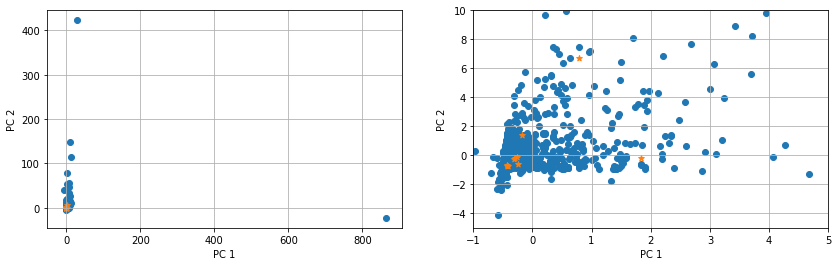

In [96]:
scatter(dpca, e_10, [[-1, 5], [-5, 10]])

In [101]:
e_10_2 = pca.transform(sc.transform(res[0][-1][1:]))

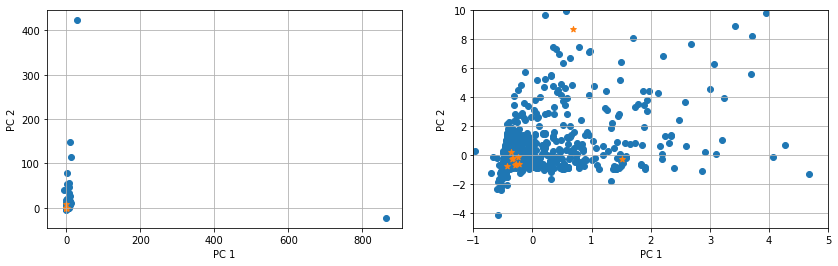

In [103]:
scatter(dpca, e_10_2, [[-1, 5], [-5, 10]])

In [97]:
e_50 = pca.transform(sc.transform(res[4][-1][1:]))

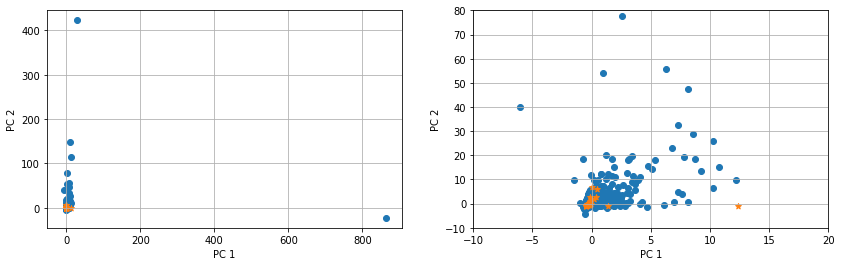

In [100]:
scatter(dpca, e_50)

Al parecer el algoritmo agrupa los datos correctamente. Se puede notar la diferencia de centroides obtenidos debido a la inicialización de estos.

## Conclusiones

En esta tarea implementamos el algoritmo $k$-means para la manipulación de una cantidad considerable de datos utilizando el *Framework Spark*. Se obtuvieron resultados interesantes sobre todo en los tiempos de ejecución considerando el volumen de datos con el que se trabajó.

Las principal desventaja de este algoritmo es la sensibilidad a la selección de centroides iniciales, es decir, se obtienen distintos resultados según la inicialización que se utilice. Para este ejemplo se inicializó con una muestra aleatoria de los datos.

El procesamiento de grandes volumenes de datos es una problemática latente en la actualidad, por lo que herramientas como *Spark* nos permiten manipularlos de una forma un poco más cómoda. Principalmente esta herramienta evita el manejo explícito de técnicas de alto rendimiento como programación paralela o distribuida.

La mayor dificultad de este trabajo estuvo en la configuración de las herramientas y dependencias para el funcionamiento del *Framework*. 

## Referencias

1. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
2. https://en.wikipedia.org/wiki/K-means_clustering